In [12]:
import numpy as np
from collections import Counter

In [13]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature # feature index to split on
        self.threshold = threshold # threshold value for split
        self.right = right # right child
        self.left = left # left child
        self.value = value # value if leaf node for prediction

    def is_leaf(self):
        return self.value is not None
        

In [14]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
    
    def fit(self, X, y):
        # Ensure n_features doesn't exceed actual features
        self.n_features = X.shape[1] if not self.n_features else min(self.n_features, X.shape[1])
        self.root = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        
        # Check if we should stop growing (FIXED: added empty check)
        if (depth >= self.max_depth or n_labels == 1 or 
            n_samples < self.min_samples_split or n_samples == 0):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # Find best split
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)
        
        # If no split improves information gain, return leaf
        if best_feat is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        
        # Recursively grow left and right subtrees
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        
        return Node(best_feat, best_thresh, left, right)
    
    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        
        return split_idx, split_thresh
    
    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)
        
        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)
        
        # If either split is empty, return 0 gain
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # Calculate weighted entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        
        # Information gain
        information_gain = parent_entropy - child_entropy
        return information_gain
    
    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs
    
    def _entropy(self, y):
        # Handle empty array case
        if len(y) == 0:
            return 0
            
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])
    
    def _most_common_label(self, y):
        # Handle empty array case
        if len(y) == 0:
            return 0  # Return default class when no samples
            
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

DECISION TREE VISUAL TEST SUITE

QUICK PERFORMANCE TEST
Training Accuracy: 1.000
Test Accuracy: 0.950
Overfitting: 0.050

First 10 predictions vs actual:
Predicted: [0 0 1 0 0 1 0 1 1 1]
Actual:     [0 0 1 0 0 1 0 1 1 1]
Linear   | Best Depth: 3 | Test Accuracy: 0.922
Moons    | Best Depth: 5 | Test Accuracy: 0.922
Circles  | Best Depth: 5 | Test Accuracy: 0.900


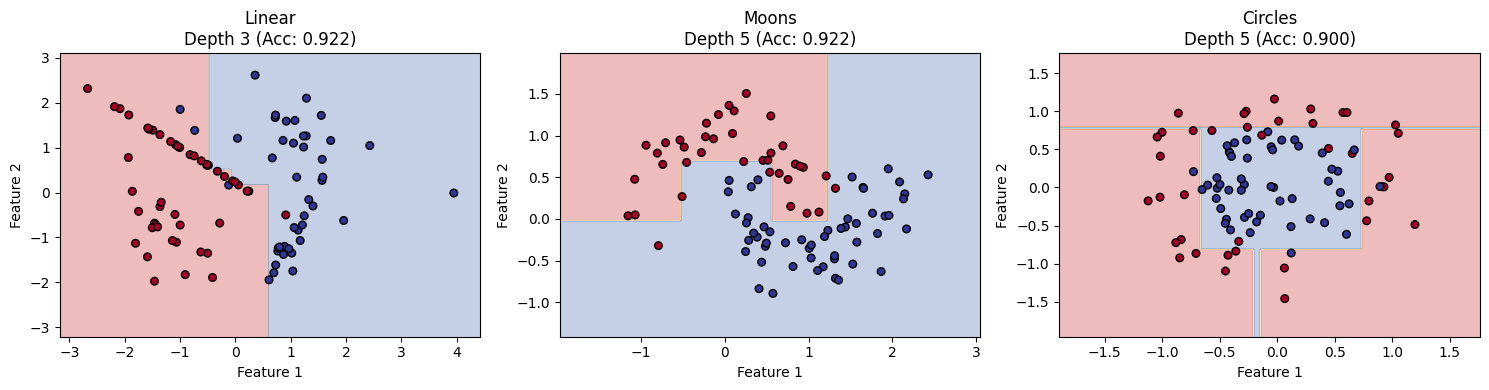


OVERFITTING TEST
Depth | Train Acc | Test Acc | Overfit
----------------------------------------
    1 |     0.900 |    0.833 |   0.067
    2 |     0.907 |    0.850 |   0.057
    3 |     0.929 |    0.817 |   0.112
    5 |     0.979 |    0.800 |   0.179
   10 |     1.000 |    0.800 |   0.200
   20 |     1.000 |    0.800 |   0.200


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def test_decision_tree_visual():
    """Visual test suite for the Decision Tree"""
    
    # Create multiple test datasets
    datasets = {
        'Linear': make_classification(n_samples=300, n_features=2, n_redundant=0, 
                                    n_informative=2, random_state=42),
        'Moons': make_moons(n_samples=300, noise=0.2, random_state=42),
        'Circles': make_circles(n_samples=300, noise=0.2, factor=0.5, random_state=42)
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for idx, (dataset_name, (X, y)) in enumerate(datasets.items()):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Test different tree depths
        best_test_acc = 0
        best_depth = 0
        best_model = None
        
        for depth in [2, 3, 5]:
            dt = DecisionTree(max_depth=depth, min_samples_split=2)
            dt.fit(X_train, y_train)
            
            test_acc = accuracy_score(y_test, dt.predict(X_test))
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                best_depth = depth
                best_model = dt
        
        # Create mesh grid for decision boundaries
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                           np.arange(y_min, y_max, 0.02))
        
        # Predict on mesh grid
        Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
        axes[idx].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                         cmap=plt.cm.RdYlBu, edgecolors='black', s=30)
        axes[idx].set_title(f'{dataset_name}\nDepth {best_depth} (Acc: {best_test_acc:.3f})')
        axes[idx].set_xlabel('Feature 1')
        axes[idx].set_ylabel('Feature 2')
        
        print(f"{dataset_name:8} | Best Depth: {best_depth} | Test Accuracy: {best_test_acc:.3f}")
    
    plt.tight_layout()
    plt.show()

def test_overfitting():
    """Test for overfitting with different depths"""
    print("\n" + "="*50)
    print("OVERFITTING TEST")
    print("="*50)
    
    X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, 
                              n_informative=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    depths = [1, 2, 3, 5, 10, 20]
    
    print("Depth | Train Acc | Test Acc | Overfit")
    print("-" * 40)
    
    for depth in depths:
        dt = DecisionTree(max_depth=depth)
        dt.fit(X_train, y_train)
        
        train_acc = accuracy_score(y_train, dt.predict(X_train))
        test_acc = accuracy_score(y_test, dt.predict(X_test))
        overfit = train_acc - test_acc
        
        print(f"{depth:5} | {train_acc:9.3f} | {test_acc:8.3f} | {overfit:7.3f}")

def quick_performance_test():
    """Quick performance test on a simple dataset"""
    print("\n" + "="*50)
    print("QUICK PERFORMANCE TEST")
    print("="*50)
    
    X, y = make_classification(n_samples=100, n_features=3, n_redundant=0, 
                              random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    dt = DecisionTree(max_depth=4)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    
    print(f"Training Accuracy: {train_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")
    print(f"Overfitting: {train_acc - test_acc:.3f}")
    
    # Show some predictions vs actual
    print("\nFirst 10 predictions vs actual:")
    print("Predicted:", test_pred[:10])
    print("Actual:    ", y_test[:10])

# Run all tests
if __name__ == "__main__":
    print("DECISION TREE VISUAL TEST SUITE")
    print("="*50)
    
    quick_performance_test()
    test_decision_tree_visual()
    test_overfitting()